In [39]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation
import magpylib as magpy
import os
import pandas as pd

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])

In [40]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def getField_cylinder(x, positions, M0, shape):
    B=magpy.getB(
        sources="Cylinder",
        position=x[:3],
        orientation=Rotation.align_vectors(x[3:], np.array([0, 0, 1]))[0],
        observers=positions,
        dimension=shape,
        polarization=(0, 0, M0),
    )
    return B

def cost_cylinder(x, B, positions, M0, shape):
    diff = getField_cylinder(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)

def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Index')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def comp_plot3D(locact, locpred, xact, yact, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    fig = go.Figure(data=[
        go.Scatter3d(x=xact, y=yact, z=pred, name='Predicted' + rel),
        go.Scatter3d(x=xact, y=yact, z=act, name='Actual' + rel)])
    fig.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Index')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def importfitting(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    print(len(file_list))
    data = np.load(file_list[0])
    pos = data['pos'][0]

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        data = np.load(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return pos, mags, locpred, anglepred, Bstdev

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

In [63]:
folder = os.path.join('..', './MLX09032024_GammaKnife')
pos, mags, locpred, anglepred, Bstdev = importfitting(folder)
np.append(locpred, anglepred, axis=1)

749


array([[-18.17963822, -61.01105313,  18.50767001,  -0.45581473,
         -0.31403475,   0.83283558],
       [-14.16722858, -62.4637784 ,  18.25938394,  -0.33586706,
         -0.39208103,   0.85642617],
       [-11.67299848, -62.67835522,  18.23910322,  -0.25659832,
         -0.40748288,   0.8764217 ],
       ...,
       [ 22.83564678,   1.79810137,  10.08034774,  -0.43665764,
         -0.33706006,   0.83409869],
       [ 22.74559477,   0.83793995,  10.51012471,  -0.47165128,
         -0.33924371,   0.81391571],
       [ 22.77075493,   0.82650598,  10.45341248,  -0.46566896,
         -0.35319203,   0.81142332]])

In [67]:
print(anglepred[:,2])

[ 0.83283558  0.85642617  0.8764217   0.85014526  0.86649693  0.84979846
  0.83943824  0.85836106  0.85511474  0.85809534  0.82988581  0.84040369
  0.87181698  0.84015942  0.85469035  0.85630278  0.85723816  0.84274642
  0.85028788  0.85470952  0.87098343  0.85427567  0.86187814  0.85007838
  0.86483718  0.85817689  0.83921781  0.85694368  0.85177323  0.85448286
  0.85430261  0.84887576  0.8599639   0.85453368  0.84004883  0.84963876
  0.8528914   0.86342431  0.85335804  0.84741444  0.8529634   0.84677351
  0.85291128  0.84629112  0.86367778  0.83811011  0.86269344  0.86089271
  0.85370338  0.84766548  0.85113946  0.84300876  0.85086743  0.85400983
  0.86095693  0.83559458  0.84649258  0.84664863  0.84819334  0.84949834
  0.84614677  0.84094306  0.85549433  0.8253961   0.83973059  0.83735042
  0.84166618  0.85771845  0.84836715  0.83532441  0.84371878  0.83066113
  0.83890667  0.84775143  0.84269698  0.85450755  0.84430651  0.85549933
  0.83640992  0.84056808  0.85391176  0.84696802  0

In [42]:
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

all_mags = [np.array([0,0,0])]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    all_mags = np.append(all_mags, mags[0], axis=0)
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
all_mags = np.delete(all_mags, 0, axis=0)

print(all_mags)
bx = all_mags[:,0]
by = all_mags[:,1]
bz = all_mags[:,2]

print(bx)
len(bx)

[[-2.73000e-02 -2.10000e-02 -2.27480e-02]
 [-4.50000e-03 -2.46000e-02 -8.71200e-03]
 [ 5.70000e-03 -8.46000e-02  4.84000e-04]
 ...
 [-2.61600e-01  4.03500e-01 -2.50712e-01]
 [-3.22200e-01  6.87000e-02  4.13336e-01]
 [-5.28600e-01  2.10300e-01  6.89700e-01]]
[-0.0273 -0.0045  0.0057 ... -0.2616 -0.3222 -0.5286]


11984

In [43]:
bx7 = []
by7 = []
bz7 = []
for x in range(len(bx)):
    if x % 16 == 6:
        bx7.append(bx[x])
        by7.append(by[x])
        bz7.append(bz[x])
print(bx7)
print(pos)

[0.020099999999999996, 0.0192, 0.0186, 0.0195, 0.0186, 0.0177, 0.0195, 0.0195, 0.0174, 0.0198, 0.0186, 0.021, 0.0177, 0.018, 0.0186, 0.0195, 0.0183, 0.0186, 0.0198, 0.0177, 0.0183, 0.0186, 0.0186, 0.0186, 0.0189, 0.0195, 0.018, 0.018, 0.0195, 0.020099999999999996, 0.020099999999999996, 0.0174, 0.020099999999999996, 0.0174, 0.0177, 0.020099999999999996, 0.0189, 0.0186, 0.0198, 0.0183, 0.0192, 0.0186, 0.0189, 0.0198, 0.0183, 0.0195, 0.020399999999999998, 0.0183, 0.0192, 0.0183, 0.0192, 0.018, 0.0189, 0.0183, 0.0192, 0.0177, 0.0198, 0.0183, 0.017099999999999997, 0.0198, 0.0174, 0.0192, 0.0195, 0.0192, 0.0192, 0.0192, 0.0183, 0.0207, 0.0174, 0.018, 0.021, 0.0198, 0.017099999999999997, 0.0189, 0.018, 0.020399999999999998, 0.0183, 0.0174, 0.020399999999999998, 0.0189, 0.0192, 0.0183, 0.0189, 0.018, 0.018, 0.021, 0.0183, 0.0198, 0.0195, 0.0192, 0.0177, 0.0177, 0.020399999999999998, 0.018, 0.0189, 0.0192, 0.0198, 0.018, 0.0186, 0.0198, 0.0192, 0.021, 0.0177, 0.0189, 0.0189, 0.018, 0.0195, 0.01

In [44]:
index = np.array(range(len(bx7)))
measuredbx = go.Scatter(x=index, y=bx7, mode='markers')
layoutbx = go.Layout(title='b_x over time')
figbx = go.Figure(data=[measuredbx], layout=layoutbx)
figbx.update_yaxes(scaleanchor='y')
figbx.update_layout(
    xaxis_title="Index",
    yaxis_title="b_x [mT]"
)
figbx.show()

In [45]:
measuredby = go.Scatter(x=index, y=by7, mode='markers')
layoutby = go.Layout(title='b_y over time')
figby = go.Figure(data=[measuredby], layout=layoutby)
figby.update_yaxes(scaleanchor='y')
figby.update_layout(
    xaxis_title="Index",
    yaxis_title="b_y [mT]"
)
figby.show()

In [46]:
measuredbz = go.Scatter(x=index, y=bz7, mode='markers')
layoutbz = go.Layout(title='b_z over time')
figbz = go.Figure(data=[measuredbz], layout=layoutbz)
figbz.update_yaxes(scaleanchor='y')
figbz.update_layout(
    xaxis_title="Index",
    yaxis_title="b_z [mT]"
)
figbz.show()

In [58]:
# Specify the Excel file name (replace with your actual file name)
file = 'Shift_data.txt'

# Create the full file path
file_path = os.path.join('..', file)

# Read the Excel file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter=',', na_values="        NaN")

df.dropna(inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

print(df)
hdmm_disp = df.loc[0:,'Displacement [mm]']
hdmm_x = df.loc[0:, 'X']
hdmm_y = df.loc[0:, 'Y']
hdmm_z = df.loc[0:, 'Z']
print(hdmm_disp)

       No.     X     Y     Z  Displacement [mm]
4        5  0.00  0.00  0.00               0.00
5        6 -0.01  0.00  0.04               0.04
6        7 -0.01  0.00  0.02               0.02
7        8 -0.01  0.02  0.05               0.05
8        9 -0.00  0.02  0.03               0.04
...    ...   ...   ...   ...                ...
1336  1337  0.00  0.00 -0.01               0.01
1337  1338 -0.01  0.01  0.05               0.05
1338  1339 -0.00  0.01  0.03               0.03
1339  1340  0.01  0.01  0.05               0.05
1340  1341  0.01  0.01  0.04               0.04

[1311 rows x 5 columns]
4       0.00
5       0.04
6       0.02
7       0.05
8       0.04
        ... 
1336    0.01
1337    0.05
1338    0.03
1339    0.05
1340    0.04
Name: Displacement [mm], Length: 1311, dtype: float64


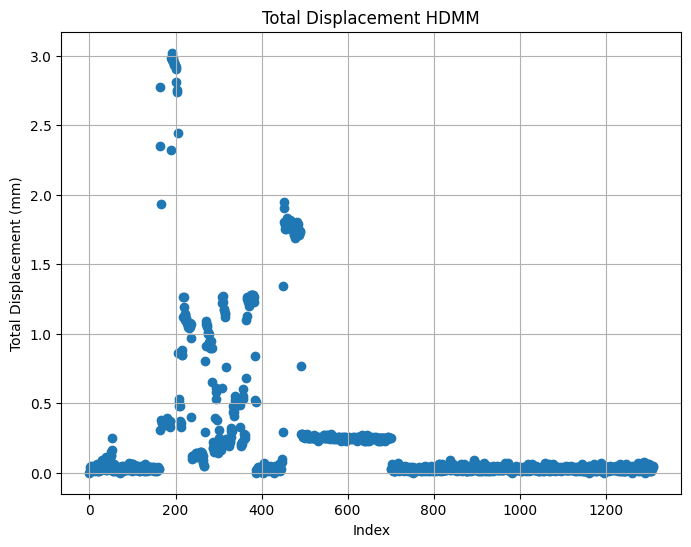

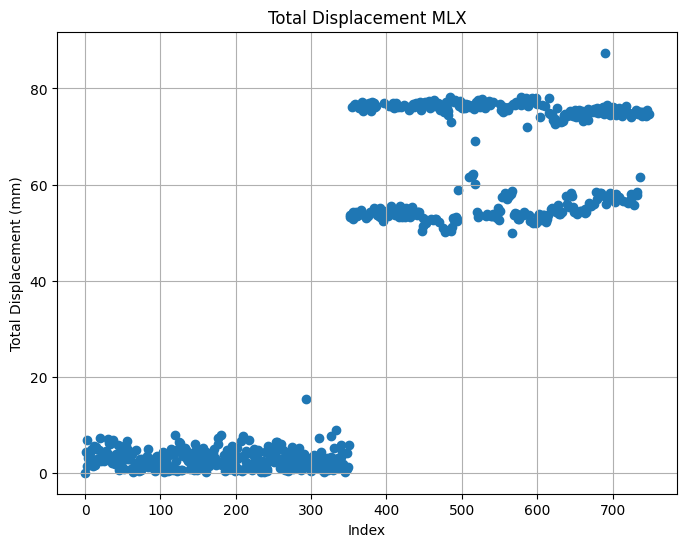

In [59]:
rel_loc_predx = [x - locpred[0,0] for x in locpred[:,0]]
rel_loc_predy = [x - locpred[0,1] for x in locpred[:,1]]
rel_loc_predz = [x - locpred[0,2] for x in locpred[:,2]]


dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(hdmm_disp))), hdmm_disp)
plt.xlabel('Index')
plt.ylabel('Total Displacement (mm)')
plt.title('Total Displacement HDMM')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(dispx))), disp)
plt.xlabel('Index')
plt.ylabel('Total Displacement (mm)')
plt.title('Total Displacement MLX')
plt.grid(True)
plt.show()

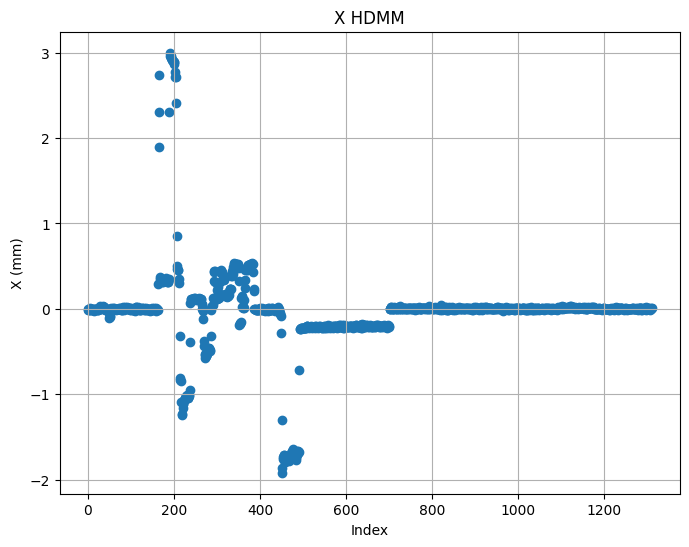

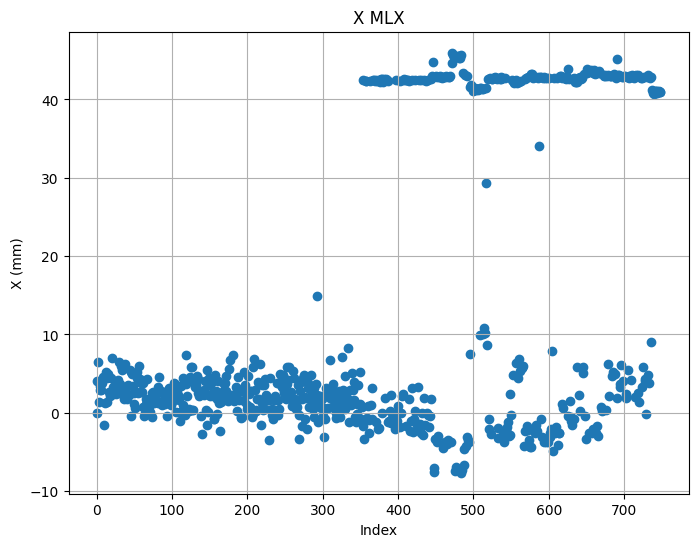

In [60]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(hdmm_x))), hdmm_x)
plt.xlabel('Index')
plt.ylabel('X (mm)')
plt.title('X HDMM')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predx))), rel_loc_predx)
plt.xlabel('Index')
plt.ylabel('X (mm)')
plt.title('X MLX')
plt.grid(True)
plt.show()

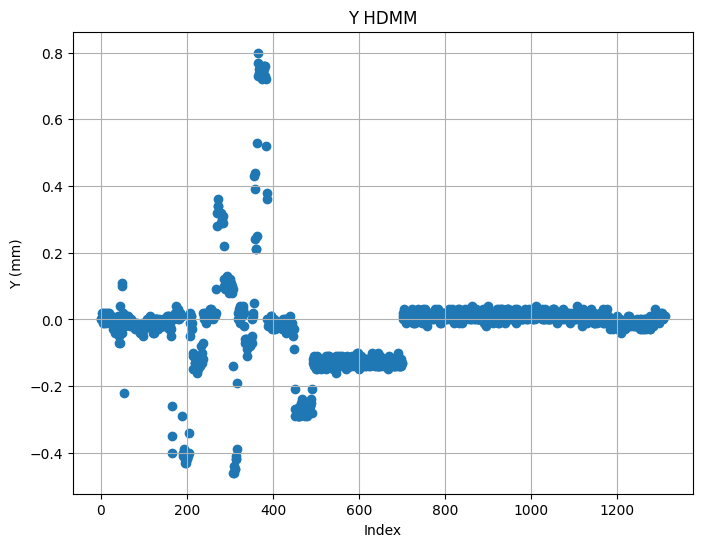

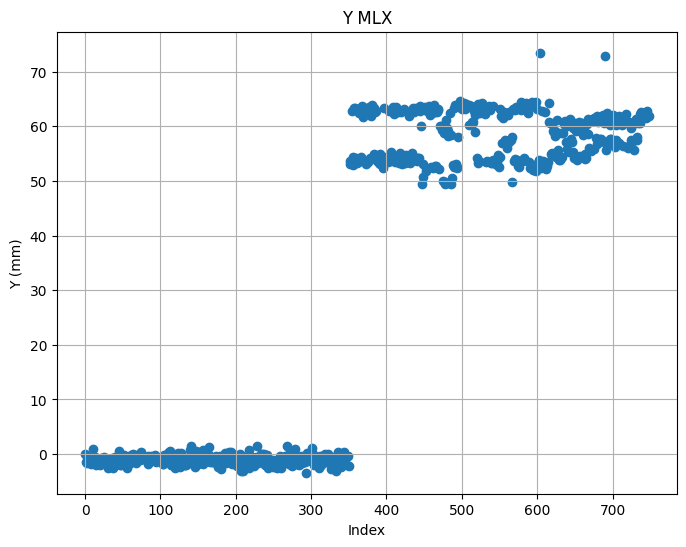

In [61]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(hdmm_y))), hdmm_y)
plt.xlabel('Index')
plt.ylabel('Y (mm)')
plt.title('Y HDMM')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predy))), rel_loc_predy)
plt.xlabel('Index')
plt.ylabel('Y (mm)')
plt.title('Y MLX')
plt.grid(True)
plt.show()

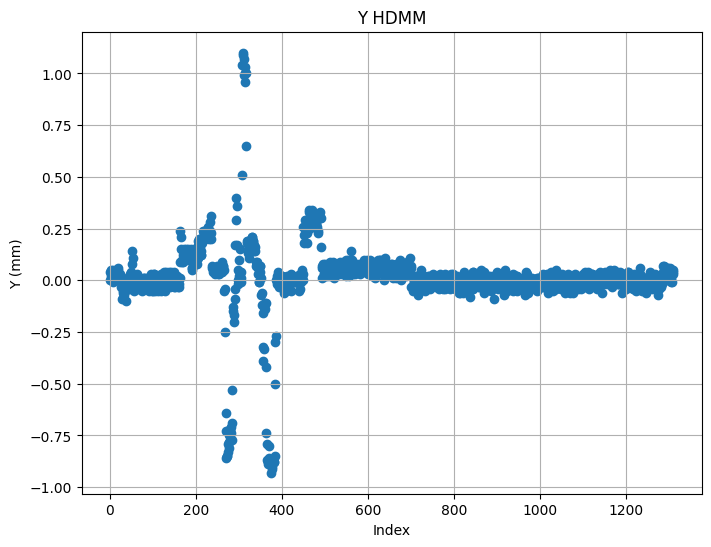

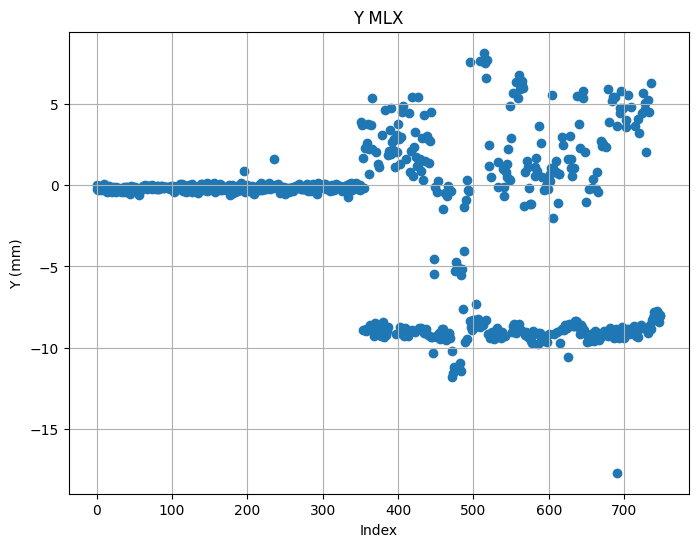

In [62]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(hdmm_z))), hdmm_z)
plt.xlabel('Index')
plt.ylabel('Y (mm)')
plt.title('Y HDMM')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predz))), rel_loc_predz)
plt.xlabel('Index')
plt.ylabel('Y (mm)')
plt.title('Y MLX')
plt.grid(True)
plt.show()